# Occlusion Maps

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.optim import SGD
from torchvision import models
import torch.nn as nn
from torch.autograd import Variable
import copy


import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map
from matplotlib.colors import LogNorm
from astropy.io import fits
import matplotlib.pyplot as plt

from skimage.transform import resize
from scipy.ndimage import gaussian_filter
from CNN_Networks import OU200_CNN, VIS_CNN, JYH_CNN, OU66_CNN
from Generate_Class_Examples import ClassSpecificImageGeneration

## Load Prediction File
In order to plot the change in prediction we need to know the original prediction made by the CNN. This can be done by reruning the CNN on the unaltered image. However for this notebook we use CSV file containing the Euclid IDs and the CNN prediction for the lens class. 

In [2]:
OU_200_Train = pd.read_csv('Explore_NN_BSGL2_Feb_4_Cluster_Final_TrainSet2_VIS-JYH-200-REVERSE_Results.csv')

## Load States
A dictionary containing all the weights for the CNNs used in the accompanning paper. 

In [3]:
loadStates = {'J': 'OU_J_Weights.pt',
              'Y': 'OU_Y_Weights.pt',
              'H': 'OU_H_Weights.pt',
              'JYH': 'OU_JYH_Weights.pt',
              'VIS': 'OU_VIS_Weights.pt',
              'OU-66': 'OU_66_Weights.pt',
              'OU-200': 'OU_200_Weights.pt'}

## Load Image
This function loads a specific image that fits the OU-200 input expectations.

In [4]:
def Get200Images(name):
    images = np.zeros((1,4,200,200))
    image_data1 = fits.getdata('EUC_J/imageEUC_J-'+str(name)+'.fits', ext=0)
    image_data1 = resize(image_data1, (200,200))
    J = (image_data1-np.amin(image_data1))/(np.amax(image_data1)-np.amin(image_data1))
    
    image_data1 = fits.getdata('EUC_Y/imageEUC_Y-'+str(name)+'.fits', ext=0)
    image_data1 = resize(image_data1, (200,200))
    Y = (image_data1-np.amin(image_data1))/(np.amax(image_data1)-np.amin(image_data1))
    
    image_data1 = fits.getdata('EUC_H/imageEUC_H-'+str(name)+'.fits', ext=0)
    image_data1 = resize(image_data1, (200,200))
    H = (image_data1-np.amin(image_data1))/(np.amax(image_data1)-np.amin(image_data1))
    
    image_data1 = fits.getdata('EUC_VIS/imageEUC_VIS-'+str(name)+'.fits', ext=0)
    #image_data1 = resize(image_data1, (200,200))
    VIS = (image_data1-np.amin(image_data1))/(np.amax(image_data1)-np.amin(image_data1))
    
    images[0,0] = J
    images[0,1] = Y
    images[0,2] = H
    images[0,3] = VIS
    
    return images

## Colour Palette
This creates a colour palette which will be red and blue at the extremes but the central value will be white. The central value in these occlusion maps is defined as the CNN prediction for the unaltered image. 

In [5]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Making Occlusion Maps
This example is for the OU-200 CNN. An empty list is defined to store the CNN predicts for each position of the occlusion pixel. 

The image is loaded for each position of the occlusion pixel to ensure the occlusion pixel is being placed over an unaltered image. The image with an occlusion pixel (4 x 4 pixels) over a section of the image is passed through the trained CNN and the output is store in the list occ_map.

Once the occlusion pixel has passed over the entire image the occ_map is converted to a numpy array and this array is reshaped into a 50 x 50 pixel image. To transform this to the same scale as the original input image, each pixel is scaled by 4 in two sets of for loops. This scaled occlusion map is returned from this function. 

In [6]:
def MakeOccMap(name, model):
    occ_map = []
    model.eval()
    image = Get200Images(name)
    image = torch.from_numpy(image)
    #print(model(image.type(torch.float)))
    for i in range(0,200,4):
        #print(i)
        for j in range(0,200,4):
            image = Get200Images(name)
            image = torch.from_numpy(image)
            image[:,:,i:i+4,j:j+4] = 0
            occ_map.append(model(image.type(torch.float))[1][1].detach().numpy())
    img_O = np.array(occ_map)
    img_O = img_O.reshape(50,50)
    resized_200 = np.zeros((200,200))
    for i in range(0, 200, 4):
        for j in range(0, 200, 4):
            resized_200[i:i+4,j:j+4] = img_O[int(i/4), int(j/4)]
    
    return resized_200

## Putting it all together 
A specific image from our data set is selected. We load in the OU-200 CNN and load in the trained weights. 

The occlusion map is created and the CNN prediction for the unaltered image is subtracted from the occlusion map. This creates an image which shows the change in CNN prediction as the occlusion pixel moves across this image. The normalisation is specified so that the minimum value will be blue (indicating a lens feature), the central value will be white (indicating no change from the unaltered image predition), and the maximum value will be red (indication a non-lens feature).

The original unaltered VIS band image is shown next to the scaled occlusion map.

/Users/sunilmcesh/Documents/Github For Paper 1/CNN_Networks.py:510: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
/Users/sunilmcesh/Documents/Github For Paper 1/CNN_Networks.py:516: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


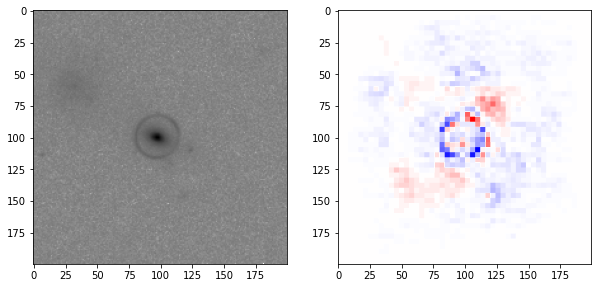

In [7]:
name = 252238
model = OU200_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.load_state_dict(torch.load(loadStates['OU-200'],map_location=torch.device('cpu')))

img_O = MakeOccMap(name, model)
img_O2 = img_O - OU_200_Train[OU_200_Train['Euclid ID'] == name]['Probability of Lens'].values[0]
midnorm = MidpointNormalize(vmin=img_O2.min(), vcenter=0, vmax=img_O2.max())
                            
img = Get200Images(name)
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(img[0,3], norm=LogNorm(), cmap='Greys')
plt.subplot(1,2,2)
plt.imshow(img_O2, cmap='bwr', norm=midnorm)
plt.show()